In [1]:
%pylab inline

import numpy as np
import pandas as pd
from astropy import units as u

print(np.__version__, pd.__version__)
%config InlineBackend.figure_format = 'retina'

Populating the interactive namespace from numpy and matplotlib
1.12.1 0.20.1


Read in the dataframes which I have extracted from the Dask files and added analysis flags and variables to.

In [2]:
#path = '/global/cscratch1/sd/cwalter/'

path = '/Users/walter/LSST/DC1/DC1-HDF5/'

#with pd.HDFStore(path + 'analysis-dataframes.h5') as f:
#    analysis = f['analysis']
    
with pd.HDFStore(path + 'truth-dataframes.h5') as f:
    stars = f['stars']
    galaxies = f['galaxies']
    
with pd.HDFStore(path + 'matched-dataframes.h5') as f:
    matched = f['matched']

Define analysis flag cuts.

In [3]:
cut_primary = 'detect_isPrimary'

cut_pixel ='not (base_PixelFlags_flag_interpolatedCenter or \
    base_PixelFlags_flag_saturatedCenter)' 

cut_model = 'not (base_PsfFlux_flag or modelfit_CModel_flag)' 

cut_flux = 'base_PsfFlux_flux > 0 and modelfit_CModel_flux > 0'

cut_list = [cut_primary, cut_pixel, cut_model, cut_flux]

cut = ' and '.join(cut_list) 

Restrict the matched catalog to good objects and only one match per object.  Choose the catalog member with the closest magnitude.

In [4]:
#Sometime usefull

restricted_columns = ['coord_ra','coord_dec', 'psfMag', 'cmodelMag','comb_mag',
                      'extendedness', 'object_class', 'sindex', 'match_index']

In [5]:
%%time

single =  matched.query(cut) \
    .query('distance < 1.0') \
    .assign(mag_diff = lambda x: 
            np.where(x.object_class == "stars", x.psfMag, x.cmodelMag) - x.comb_mag) \
    .assign(abs_mag_diff = lambda x: x.mag_diff.abs()) \
    .sort_values('abs_mag_diff')\
    .groupby('match_index').first()

CPU times: user 46.7 s, sys: 34.5 s, total: 1min 21s
Wall time: 1min 13s


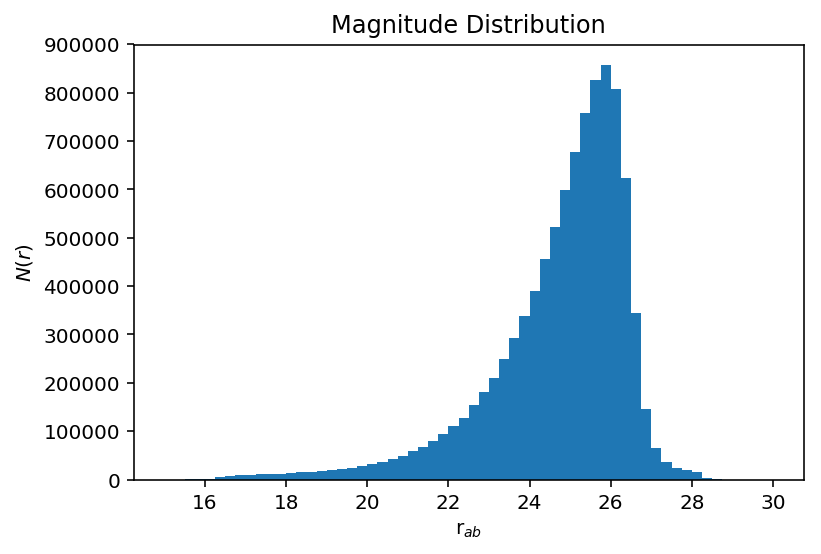

In [6]:
single.hist('comb_mag', bins=60, range=(15,30), grid=False)

plt.title('Magnitude Distribution')
plt.xlabel(r'r$_{ab}$')
plt.ylabel(r'$N(r)$')

Plot the sky locations.

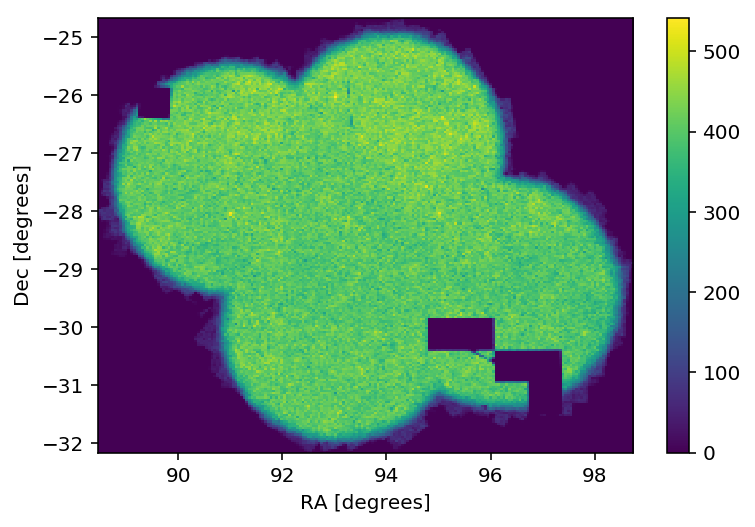

In [7]:
#good.assign(ra = lambda x: x.coord_ra*180/pi) \
#    .assign(dec = lambda x: x.coord_dec*180/pi) \
#    .plot.hexbin('ra', 'dec', gridsize=75)

ra = single['coord_ra']*180/pi
dec = single['coord_dec']*180/pi

plt.hist2d(ra, dec, bins=200)
plt.xlabel('RA [degrees]')
plt.ylabel('Dec [degrees]')
plt.colorbar()

Now we would like to plot a very simple single band star galaxy seperator.  This is based on the definition in:

http://www.sdss3.org/dr8/algorithms/classify.php

Which defines extended objects as those for which:

psfMag - cmodelMag > 0.145

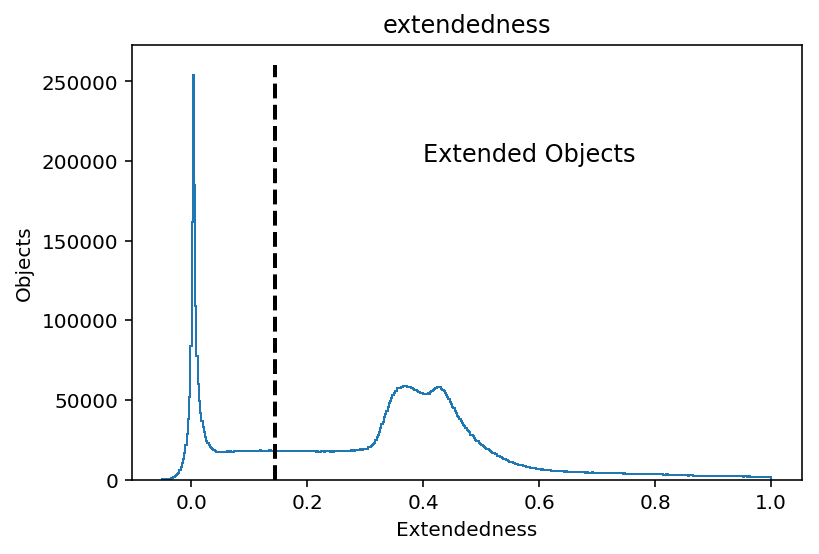

In [8]:
single.hist('extendedness', range=(-0.05,1.0), bins=500, histtype='step', grid=False)

plot([.145, .145], [0, 260000], color='k', linestyle='--', linewidth=2)
text(0.4, 200000, "Extended Objects", fontsize=12)
plt.xlabel("Extendedness")
plt.ylabel("Objects")

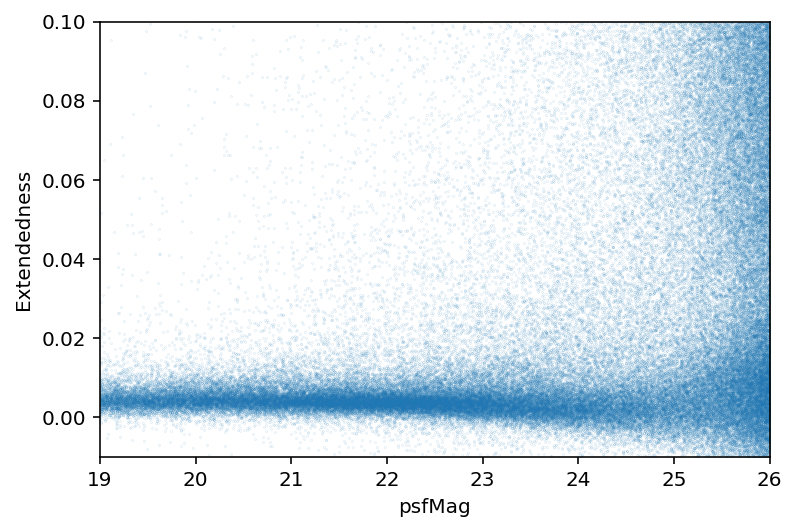

In [9]:
single[::10].plot.scatter('psfMag','extendedness', s=.01, marker=".", grid=False)

# plt.xlim(15,  30)
# plt.ylim(-0.1, 3);

plt.xlim(19,  26)
plt.ylim(-0.01, 0.10);

plt.xlabel("psfMag")
plt.ylabel("Extendedness")

Do the same but now use the matched truth information.  Red for stars, Blue for galaxies.

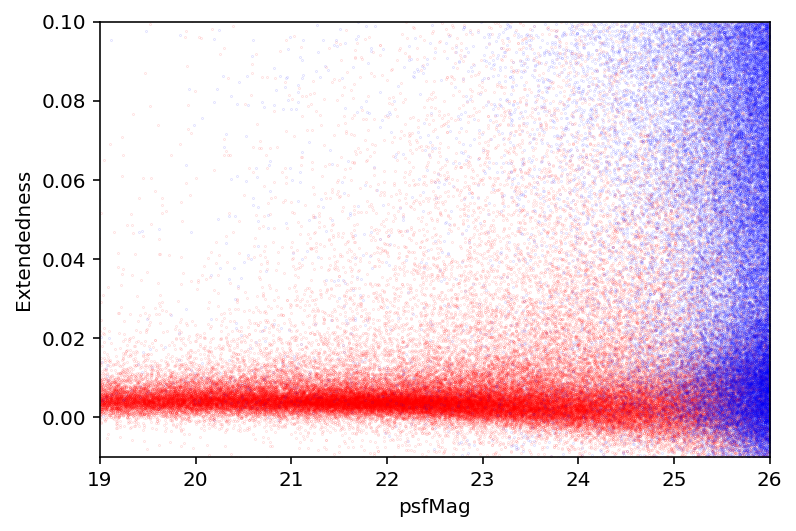

In [10]:
ax1 = single[::10].query('object_class=="stars"').\
    plot.scatter('psfMag','extendedness', s=.01, marker=".", color='red', grid=False)
ax2 = single[::10].query('object_class=="galaxies"').\
    plot.scatter('psfMag','extendedness', s=.01, marker=".", color='blue', grid=False, ax=ax1)

# plt.xlim(15,  30)
# plt.ylim(-0.1, 3);

plt.xlim(19,  26)
plt.ylim(-0.01, 0.10);

plt.xlabel("psfMag")
plt.ylabel("Extendedness")

1D Projection

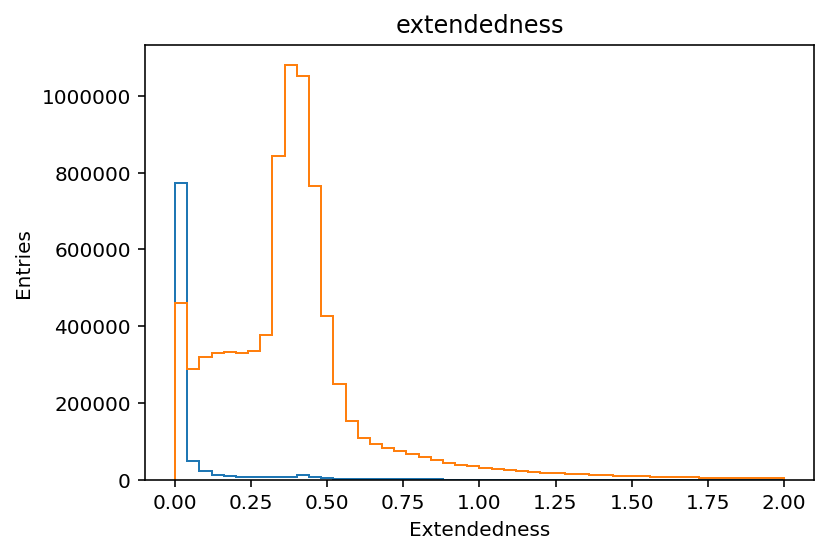

In [11]:
ax1 = single.query('object_class == "stars"').hist('extendedness', histtype='step', bins=50, range=[0, 2], grid=False)
ax2 = single.query('object_class == "galaxies"').hist('extendedness', histtype='step', bins=50, range=[0, 2], grid=False, ax=ax1)

plt.xlabel("Extendedness")
plt.ylabel("Entries")

Now let's explore the content of the truth catalogs.

In [12]:
print("There are", galaxies.shape[0]/1e6, "million galaxies in the DataFrame")

There are 47.362889 million galaxies in the DataFrame


First let's look at the distributions of the stars and galaxies. nindex is the Sersic profile index ($n$). Setting n = 4 gives the de Vaucouleurs profile:

$$ I(R) \propto e^{-kR^{1/4}} $$ 

which is a good description of giant elliptical galaxies while setting n = 1 gives the exponential profile which is a good description of spiral galaxy disks and dwarf elliptical galaxies:

$$ I(R) \propto e^{-kR} $$

This corresponds to CatSim type 26 (de Vaucouleurs) and 27 (exponential) respectively.  This type is encoded in the right most 10 bits of the id.

In [13]:
galaxies.head()

,raICRS,decICRS,r_mag,redshift,majorAxis,minorAxis,positionAngle,sindex,sub_type,num_components,comb_mag
new_id,,,,,,,,,,,
100400000004,91.914231,-31.610165,15.8975,0.041331,0.000018,0.000011,3.552020,4.0,26,2,14.869518
100400000016,91.902160,-31.587782,15.5416,0.041346,0.000038,0.000025,1.525050,4.0,26,2,15.382225
100400000022,91.593128,-31.361955,12.9497,0.096946,0.000005,0.000003,1.027470,1.0,27,1,12.949700
100400000034,91.118241,-31.552100,14.4423,0.270154,0.000004,0.000001,1.292970,1.0,27,1,14.442300
100400000045,91.868344,-31.561261,14.7854,0.162465,0.000006,0.000004,0.096176,1.0,27,1,14.785400


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x2b8f861d0>]], dtype=object)

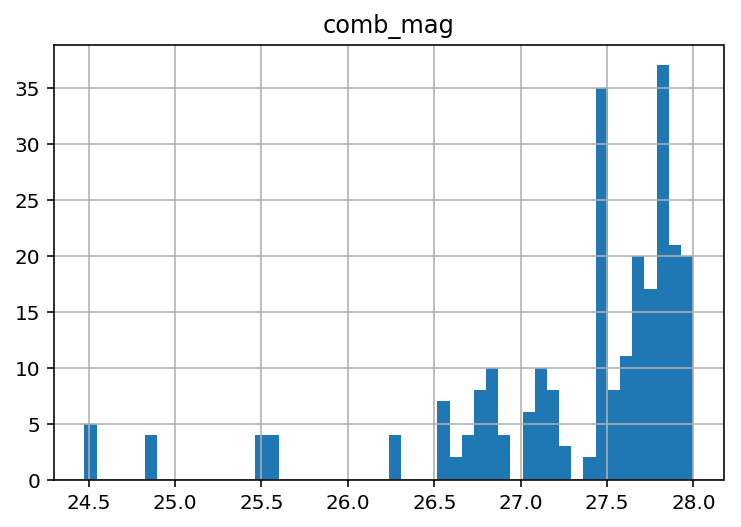

In [14]:
galaxies.query('redshift>10').hist('comb_mag', bins=50)

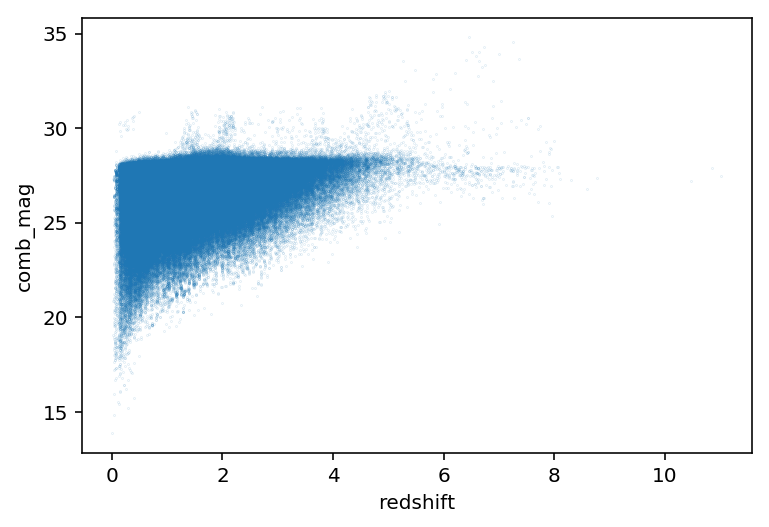

In [15]:
galaxies[::100].plot.scatter('redshift', 'comb_mag', s=.01, marker=".")

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x2b6d4b940>]], dtype=object)

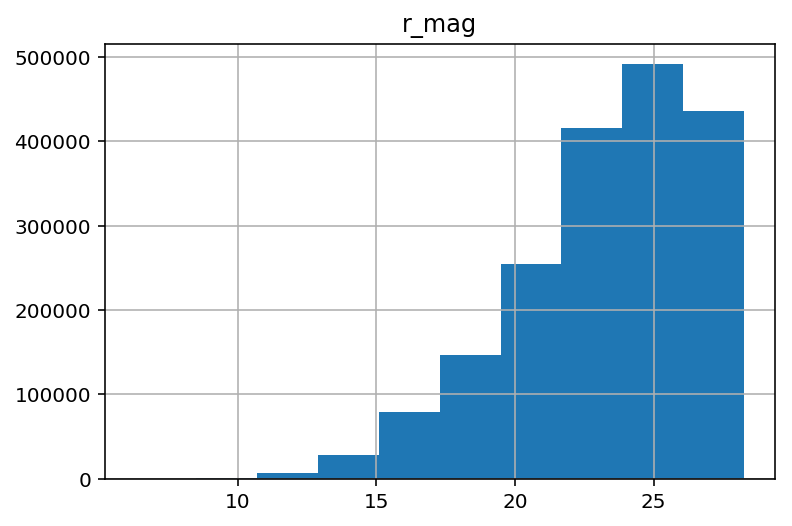

In [16]:
stars.hist('r_mag')

Now let's do astrometry checks.

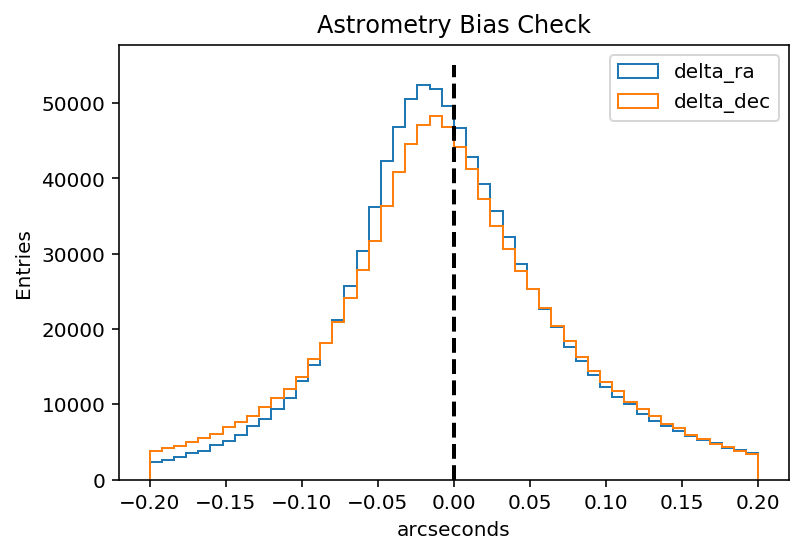

In [34]:
single.query('object_class == "stars"')\
    .assign(delta_ra = lambda x: ( x.coord_ra - x.raICRS*pi/180)*206264.806) \
    .assign(delta_dec = lambda x: (x.coord_dec - x.decICRS*pi/180)*206264.806) \
    [['delta_ra','delta_dec']] \
    .plot.hist(bins=50, histtype='step', range=[-0.2,0.2]);

plot([0, 0], [0, 55000], color='k', linestyle='--', linewidth=2)
#plot([0, 0], [0, 9000], color='k', linestyle='--', linewidth=2)
 

plt.title("Astrometry Bias Check")
#plt.ylim(0,38000)
plt.xlabel("arcseconds")
plt.ylabel("Entries")

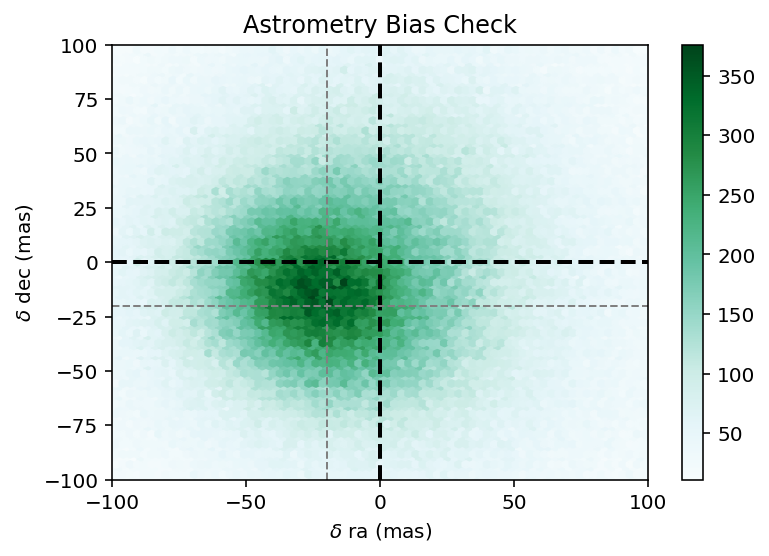

In [36]:
single.query('object_class == "stars"') \
    .assign(delta_ra = lambda x: (x.coord_ra - x.raICRS*pi/180 )*206264806) \
    .assign(delta_dec = lambda x: (x.coord_dec - x.decICRS*pi/180)*206264806) \
    .plot.hexbin('delta_ra', 'delta_dec', gridsize=75, 
                 extent=[-100.0, 100.0, -100.0, 100.0], sharex=False)
    
plt.title("Astrometry Bias Check")
plot([0.0, 0.0], [-100, 100], color='k', linestyle='--', linewidth=2)
plot([-100, 100], [0.0, 0.0], color='k', linestyle='--', linewidth=2)
plot([-20.0, -20.0], [-100, 100], color='grey', linestyle='--', linewidth=1.0)
plot([-100, 100], [-20.0, -20.0], color='grey', linestyle='--', linewidth=1.0)

plt.xlabel("$\delta$ ra (mas)");
plt.ylabel("$\delta$ dec (mas)");

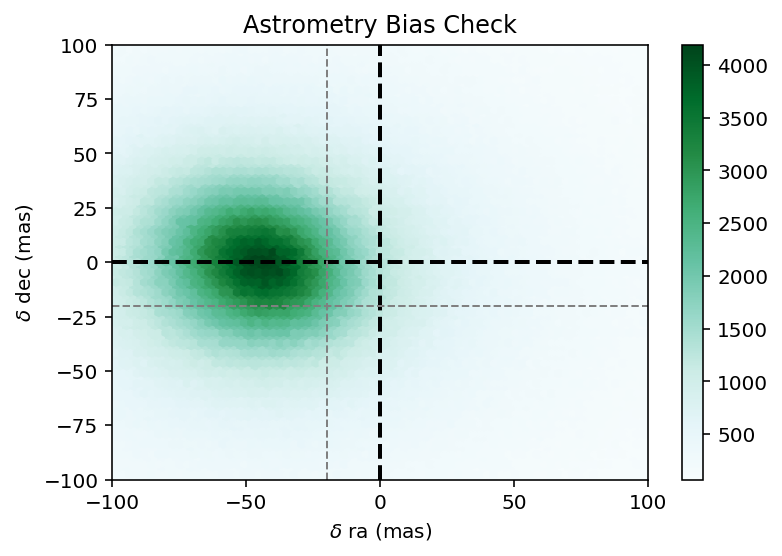

In [35]:
single.query('object_class == "galaxies"') \
    .assign(delta_ra = lambda x: (x.coord_ra - x.raICRS*pi/180)*206264806) \
    .assign(delta_dec = lambda x: (x.coord_dec - x.decICRS*pi/180 )*206264806) \
    .plot.hexbin('delta_ra', 'delta_dec', gridsize=75, 
                 extent=[-100.0, 100.0, -100.0, 100.0], sharex=False)
    
plt.title("Astrometry Bias Check")
plot([0.0, 0.0], [-100, 100], color='k', linestyle='--', linewidth=2)
plot([-100, 100], [0.0, 0.0], color='k', linestyle='--', linewidth=2)
plot([-20.0, -20.0], [-100, 100], color='grey', linestyle='--', linewidth=1.0)
plot([-100, 100], [-20.0, -20.0], color='grey', linestyle='--', linewidth=1.0)

plt.xlabel("$\delta$ ra (mas)");
plt.ylabel("$\delta$ dec (mas)");

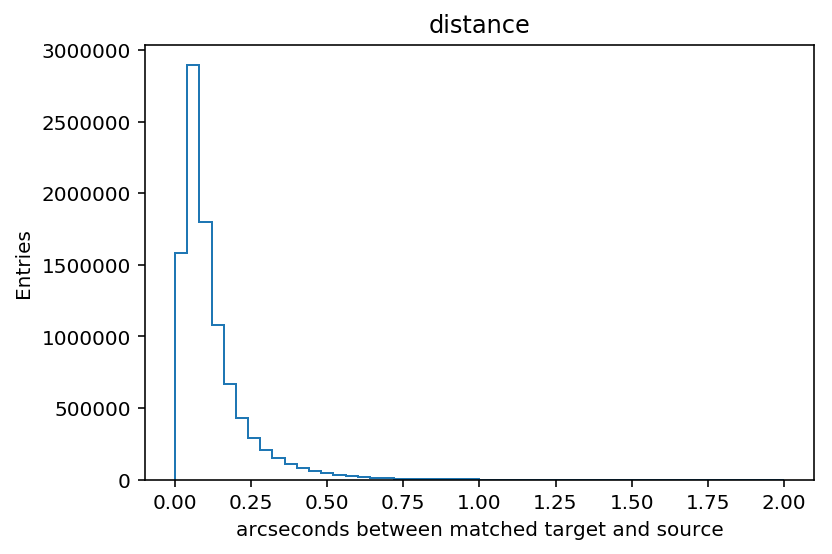

In [20]:
single.hist('distance', bins=50, range=[0,2], histtype='step', grid=False)
plt.xlabel("arcseconds between matched target and source")
plt.ylabel("Entries")

(-0.25, 0.25)

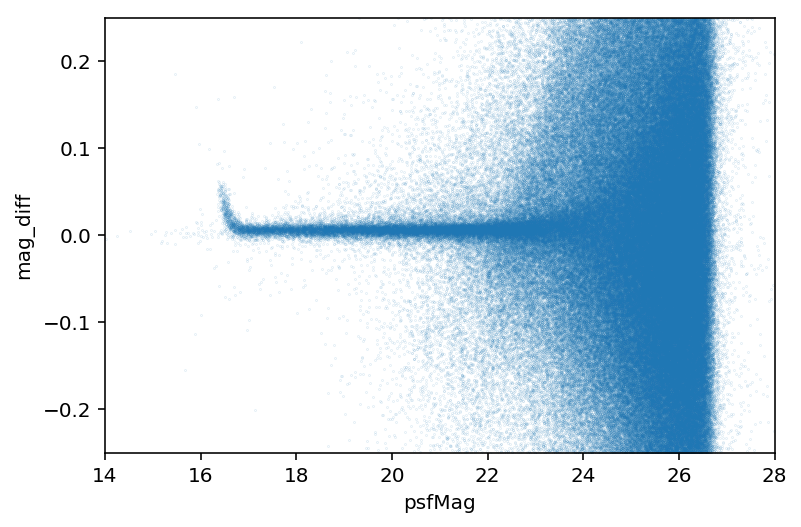

In [21]:
single[::20].plot.scatter('psfMag', 'mag_diff', marker=".", s=.01)
plt.xlim(14,  28)
plt.ylim(-0.25,  0.25)

In [22]:
%%script False

matched.assign(mag_diff = lambda x: 
            np.where(x.object_class == "stars", x.psfMag, x.cmodelMag) - x.comb_mag) \
    .assign(abs_mag_diff = lambda x: x.mag_diff.abs()) \
    .sort_values('abs_mag_diff') \
    .groupby('match_index').get_group(1858597)